## Nuclear segmentation of TCGA data

The tissue cancer atlas (TCGA) contains a wealth of information that can be used to power machine learning models. This notebook outlines how to use our tcga_utils library to download whole slide images in the TCGA by uuid and convert them to a cell graph. 

In [1]:
# Import packages
from tcga_utils import download_utils
from tcga_utils import wsi_utils
from matplotlib import pyplot as plt

import openslide
import pandas as pd
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Load the manifest file that was downloaded from the TCGA website. 
# This contains the uuids of all the samples thathave whole slide imaging
# data

df = download_utils.load_manifest_file('/data/manifest/gdc_manifest.2020-01-07.txt')

In [2]:
# Download the wsi associated with the uuid

wsi_file = download_utils.download_by_uuids('b7df26c0-d3f3-4206-912b-14b0d93e2506', save_direc = '/data/TCGA')
print(wsi_file)

/data/TCGA/TCGA-HV-AA8X-01A-01-TS1.200784C7-EAA4-4AF3-9938-1804F9675C13.svs


In [3]:
# Load the slide using openslide

wsi_file = '/data/TCGA/TCGA-HV-AA8X-01A-01-TS1.200784C7-EAA4-4AF3-9938-1804F9675C13.svs'
slide = wsi_utils.open_slide(wsi_file)

In [4]:
# Convert the wsi to tiles. Note we set mpp (microns per pixel) to 0.5, 
# which is effectively 20X resolution.

tiles, tile_locations = wsi_utils.slide_to_tiles(slide, 
                                                 new_mpp=0.5, 
                                                 tile_size=512, 
                                                 overlap=0, 
                                                 return_locations=True)

In [5]:
# Filter tiles to identify the ones that have >25% tissue
filtered_tiles, filtered_locations = wsi_utils.filter_tiles(tiles, 
                                                   tissue_threshold=25, 
                                                   return_locations=True)
filtered_tile_locations = tile_locations[filtered_locations]

Displaying tile 59 of 82


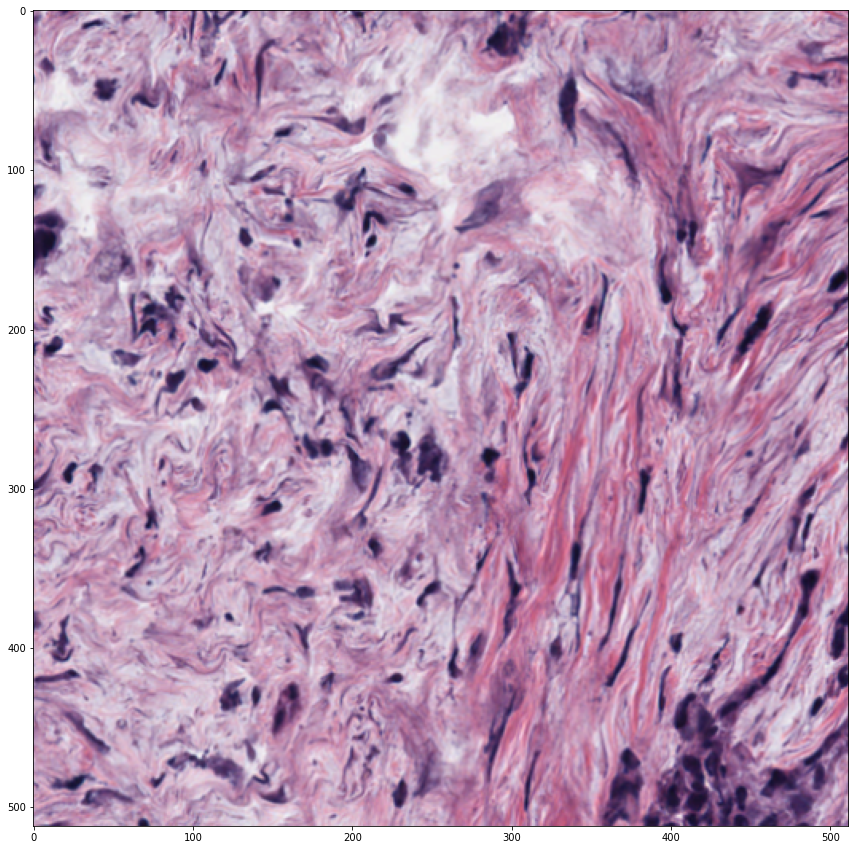

In [6]:
# Display a tile as a sanity check
n_tiles = filtered_tiles.shape[0]
index = np.random.choice(n_tiles)

print('Displaying tile %d of %d' %(index+1, n_tiles))

fig, axes = plt.subplots(1,1, figsize=(15,15))
axes.imshow(filtered_tiles[index,...])

## Define Application

In [7]:
from skimage.measure import regionprops, label
from skimage.morphology import watershed, extrema, disk, remove_small_objects
from skimage.segmentation import relabel_sequential
from skimage.exposure import rescale_intensity
from deepcell_toolbox.utils import erode_edges

def preprocess_hae(img):
    img = img.astype('float')
    new_img = []
    for b in img:
        new_b = rescale_intensity(b, out_range='float')
        new_img.append(new_b)
    new_img = np.stack(new_img, axis=0)
    return new_img

def postprocess_hae(outputs,
                   height=0.1, 
                   radius=5, 
                   distance_threshold=0.1,
                   small_objects_threshold=0):
    """Postprocessing function for deep watershed models. Thresholds the inner
    distance prediction to find cell centroids, which are used to seed a marker
    based watershed of the outer distance prediction. Cell type predictions are averaged to produce 
    Args:
        outputs (list): DeepWatershed model output. A list of
            [inner_distance, outer_distance, fgbg].
            - inner_distance: Prediction for the inner distance transform.
            - outer_distance: Prediction for the outer distance transform.
            - fgbg: Prediction for the foregound/background transform.
        min_distance (int): Minimum allowable distance between two cells.
        detection_threshold (float): Threshold for the inner distance.
        distance_threshold (float): Threshold for the outer distance.
        exclude_border (bool): Whether to include centroid detections
            at the border.
        small_objects_threshold (int): Removes objects smaller than this size.
    Returns:
        numpy.array: Uniquely labeled mask.
    """
    inner_distance_batch = outputs[0][:, ..., 0]
    outer_distance_batch = outputs[1][:, ..., 0]
    celltype_batch = outputs[2]

    label_images = []
    celltypes = []
    
    for batch in range(inner_distance_batch.shape[0]):
        inner_distance = inner_distance_batch[batch]
        outer_distance = outer_distance_batch[batch]
        celltype = celltype_batch[batch]

        markers = extrema.h_maxima(inner_distance,
                                  height,
                                  selem=disk(radius))
        markers = label(markers)
        label_image = watershed(-outer_distance,
                                markers,
                                mask=outer_distance > distance_threshold)
        label_image = erode_edges(label_image, 1)

        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)

        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)
        label_images.append(label_image)
        
        # Extract cell type prediction
        props = regionprops(label_image)
        celltype_array = np.zeros((len(np.unique(label_image)),))
        for prop in props:
            signal = celltype[prop.coords[:,0], prop.coords[:,1],:]
            mean_signal = np.mean(signal, axis=0)
            celltype_array[prop.label] = np.argmax(mean_signal)
        celltypes.append(celltype_array)
            
    # Stack label images
    label_images = np.stack(label_images, axis=0)

    # Stack cell types
    max_len = max([len(arr) for arr in celltypes])
    padded = np.array([np.pad(arr, (0, max_len - len(arr)), 'constant', constant_values=-1) for arr in celltypes])
    celltypes = np.stack(padded, axis=0)
    
    return label_images, celltypes

In [8]:
from deepcell.applications import Application
from tensorflow.keras.models import load_model
from deepcell import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

class HAESegmentation(Application):
    """Loads a `deepcell.model_zoo.PanopticNet` model for cytoplasm segmentation
    with pretrained weights.
    The `predict` method handles prep and post processing steps to return a labeled image.

    Args:
        model_path (str, optional): Path to pre-trained model.
        model_image_shape (tuple, optional): Shape of input data expected by model.
            Defaults to `(256, 256, 3)`
    """
    
    def __init__(self, 
                 model_path = '/data/models/pannuke_08042020',
                 model_image_shape=(256,256,3)):
        model = load_model(model_path)


        #: Metadata for the dataset used to train the model
        dataset_metadata = {
            'name': 'pannuke',
            'other': 'PanNuke dataset from University of Warwick - https://jgamper.github.io/PanNukeDataset/'
        }

        #: Metadata for the model and training process
        model_metadata = {
            'batch_size': 8,
            'lr': 1e-4,
            'lr_decay': 0.95,
            'training_seed': 0,
            'n_epochs': 32,
            'training_steps_per_epoch': 5889 // 8,
            'validation_steps_per_epoch': 1471 // 8
        }
        
        super(HAESegmentation, self).__init__(model,
                                              model_image_shape=model_image_shape,
                                              model_mpp=0.25,
                                              preprocessing_fn=preprocess_hae,
                                              postprocessing_fn=postprocess_hae,
                                              dataset_metadata=dataset_metadata,
                                              model_metadata=model_metadata)
        
    def _postprocess(self, image, **kwargs):
        """Applies postprocessing function to image if one has been defined.
        Otherwise returns unmodified image.

        Args:
            image (array or list): Input to postprocessing function
                either an array or list of arrays

        Returns:
            array: labeled image
        """

        if self.postprocessing_fn is not None:
            image, celltypes = self.postprocessing_fn(image, **kwargs)

            # Restore channel dimension if not already there
            if len(image.shape) == self.required_rank - 1:
                image = np.expand_dims(image, axis=-1)

        elif isinstance(image, list) and len(image) == 1:
            image = image[0]

        return image, celltypes
    
    def predict(self,
                image,
                batch_size=4,
                image_mpp=None,
                return_celltypes=True,
                preprocess_kwargs={},
                postprocess_kwargs={}):
        """Generates a labeled image of the input running prediction with
        appropriate pre and post processing functions.

        Input images are required to have 4 dimensions `[batch, x, y, channel]`. Additional
        empty dimensions can be added using `np.expand_dims`

        Args:
            image (np.array): Input image with shape `[batch, x, y, channel]`
            batch_size (int, optional): Number of images to predict on per batch. Defaults to 4.
            image_mpp (float, optional): Microns per pixel for the input image. Defaults to None.
            preprocess_kwargs (dict, optional): Kwargs to pass to preprocessing function.
                Defaults to {}.
            postprocess_kwargs (dict, optional): Kwargs to pass to postprocessing function.
                Defaults to {}.

        Raises:
            ValueError: Input data must match required rank of the application, calculated as
                one dimension more (batch dimension) than expected by the model

            ValueError: Input data must match required number of channels of application

        Returns:
            np.array: Labeled image
        """
    
        label_image, celltypes = self._predict_segmentation(image,
                                          batch_size=batch_size,
                                          image_mpp=image_mpp,
                                          preprocess_kwargs=preprocess_kwargs,
                                          postprocess_kwargs=postprocess_kwargs)
        
        if return_celltypes:
            return label_image, celltypes
        else: 
            return label_image
    
    def _predict_segmentation(self,
                              image,
                              batch_size=4,
                              image_mpp=None,
                              preprocess_kwargs={},
                              postprocess_kwargs={}):
        """Generates a labeled image of the input running prediction with
        appropriate pre and post processing functions.

        Input images are required to have 4 dimensions `[batch, x, y, channel]`. Additional
        empty dimensions can be added using `np.expand_dims`

        Args:
            image (np.array): Input image with shape `[batch, x, y, channel]`
            batch_size (int, optional): Number of images to predict on per batch. Defaults to 4.
            image_mpp (float, optional): Microns per pixel for the input image. Defaults to None.
            preprocess_kwargs (dict, optional): Kwargs to pass to preprocessing function.
                Defaults to {}.
            postprocess_kwargs (dict, optional): Kwargs to pass to postprocessing function.
                Defaults to {}.

        Raises:
            ValueError: Input data must match required rank of the application, calculated as
                one dimension more (batch dimension) than expected by the model

            ValueError: Input data must match required number of channels of application

        Returns:
            np.array: Labeled image
        """

        # Check input size of image
        if len(image.shape) != self.required_rank:
            raise ValueError('Input data must have {} dimensions. '
                             'Input data only has {} dimensions'.format(
                                 self.required_rank, len(image.shape)))

        if image.shape[-1] != self.required_channels:
            raise ValueError('Input data must have {} channels. '
                             'Input data only has {} channels'.format(
                                 self.required_channels, image.shape[-1]))

        # Resize image, returns unmodified if appropriate
        resized_image = self._resize_input(image, image_mpp)

        # Generate model outputs
        output_images = self._run_model(image=resized_image, batch_size=batch_size,
                                        preprocess_kwargs=preprocess_kwargs)

        # Postprocess predictions to create label image
        label_image, celltypes = self._postprocess(output_images, **postprocess_kwargs)

        # Resize label_image back to original resolution if necessary
        label_image = self._resize_output(label_image, image.shape)

        return label_image, celltypes


In [9]:
from scipy.spatial.distance import cdist
from scipy import ndimage as ndi
from scipy.spatial import Delaunay

def cell_dist(prop0, prop1):
    """ Compute minimum distance between two cells"""
    distance = cdist(prop0.coords, prop1.coords)
    min_distance = np.amin(distance)
    return min_distance
    
def plot_cell_graph(hae_image, label_image, celltypes=None):
    fig, axes = plt.subplots(1,2,figsize=(40,40))
    
    # Erode label image masks to help with visualization
    cmap = plt.get_cmap('viridis')
    cmap.set_bad('black')

    if celltypes is None:
        label_image = np.ma.masked_equal(label_image, 0)

    axes[0].imshow(hae_image)
    
    if celltypes is None:
        axes[1].imshow(label_image, cmap=cmap)
    else:
        new_label_image = np.zeros(label_image.shape)
        for cell_id in np.unique(label_image):
            cell_id = np.int(cell_id)
            new_label_image[label_image==cell_id] = celltypes[cell_id]
        new_label_image = np.ma.masked_equal(new_label_image, 0)
        axes[1].imshow(new_label_image, cmap=cmap)
        
    axes[0].set_title('H&E Image', fontsize=24)
    
    if celltypes is None:
        axes[1].set_title('Predicted Label Image', fontsize=24)
    else:
        axes[1].set_title('Cell segmentations and cell type', fontsize=24)
        
    # Plot cell graph
    props = regionprops(label_image)
    points = []
    for prop in props:
        y0, x0 = prop.centroid
        points.append(np.array([x0, y0]))
    points = np.stack(points, axis=0)
    tri = Delaunay(points)
    axes[1].triplot(points[:,0], points[:,1], tri.simplices, color='w')
    axes[1].plot(points[:, 0], points[:, 1], '.w', markersize=12.5)

    for ax in axes.flatten():
        ax.set_axis_off()    
    return axes

def plot_cell_graph_wsi(label_images, locations, celltypes=None, return_points=True):
    color_dict = {}
    color_dict['black'] = [0.,0.,0.]
    color_dict['orange'] = [230./255, 159./255, 0]
    color_dict['sky_blue'] = [86./255,180./255, 233./255]
    color_dict['bluish_green'] = [0., 158./255, 115./255]
    color_dict['yellow'] = [240./255, 228./255, 66./255]
    color_dict['blue'] = [0., 114./255, 178./255]
    color_dict['vermillion'] = [213./255, 94./255, 0]
    color_dict['reddish_purple'] = [204./255, 121./255, 167./255]
    
    
    celltypes = celltypes.astype('int')
    fig, axes = plt.subplots(1,1,figsize=(40,40))
    celltype_colors = ['reddish_purple', 'sky_blue', 'yellow', 'black', 'orange', 'vermillion']
    # Plot cell graph
    points = []
    colors = []
    for b in range(label_images.shape[0]):
        label_image = label_images[b]
        row = locations[b,0]
        col = locations[b,1]
        props = regionprops(label_image)
        for prop in props:
            y0, x0 = prop.centroid
            points.append(np.array([x0+col*512, y0+row*512]))
            if celltypes is not None:
                celltype_id = celltypes[b, prop.label]
                c = celltype_colors[celltype_id]
                colors.append(color_dict[c])
    points = np.stack(points, axis=0)
    colors = np.stack(colors, axis=0)
    tri = Delaunay(points)
#     axes.triplot(points[:,0], points[:,1], tri.simplices, color='k')
    
    if celltypes is None:
        axes.plot(points[:, 0], points[:, 1], '.k', markersize=12.5)
    else:
        axes.scatter(points[:, 0], points[:, 1], color=colors)
        
    axes.invert_yaxis()
    
    if return_points:
        if celltypes is None:
            return points
        else:
            return points, colors
    else:
        return axes
    
#     axes.set_axis_off()    
#     return axes

## Process tiles

In [10]:
np.savez('/data/filtered_tiles_paad.npz', filtered_tiles=filtered_tiles)

In [11]:
hae_app = HAESegmentation()

In [12]:
print(filtered_tiles.shape)
label_images, celltypes = hae_app.predict(filtered_tiles, image_mpp=0.5, batch_size=16)

(82, 512, 512, 3)


Displaying tile 67 of 82
(82, 512, 512, 3) (82, 512, 512, 1) (82, 334) [-1.  0.  1.  2.  3.  4.  5.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  app.launch_new_instance()


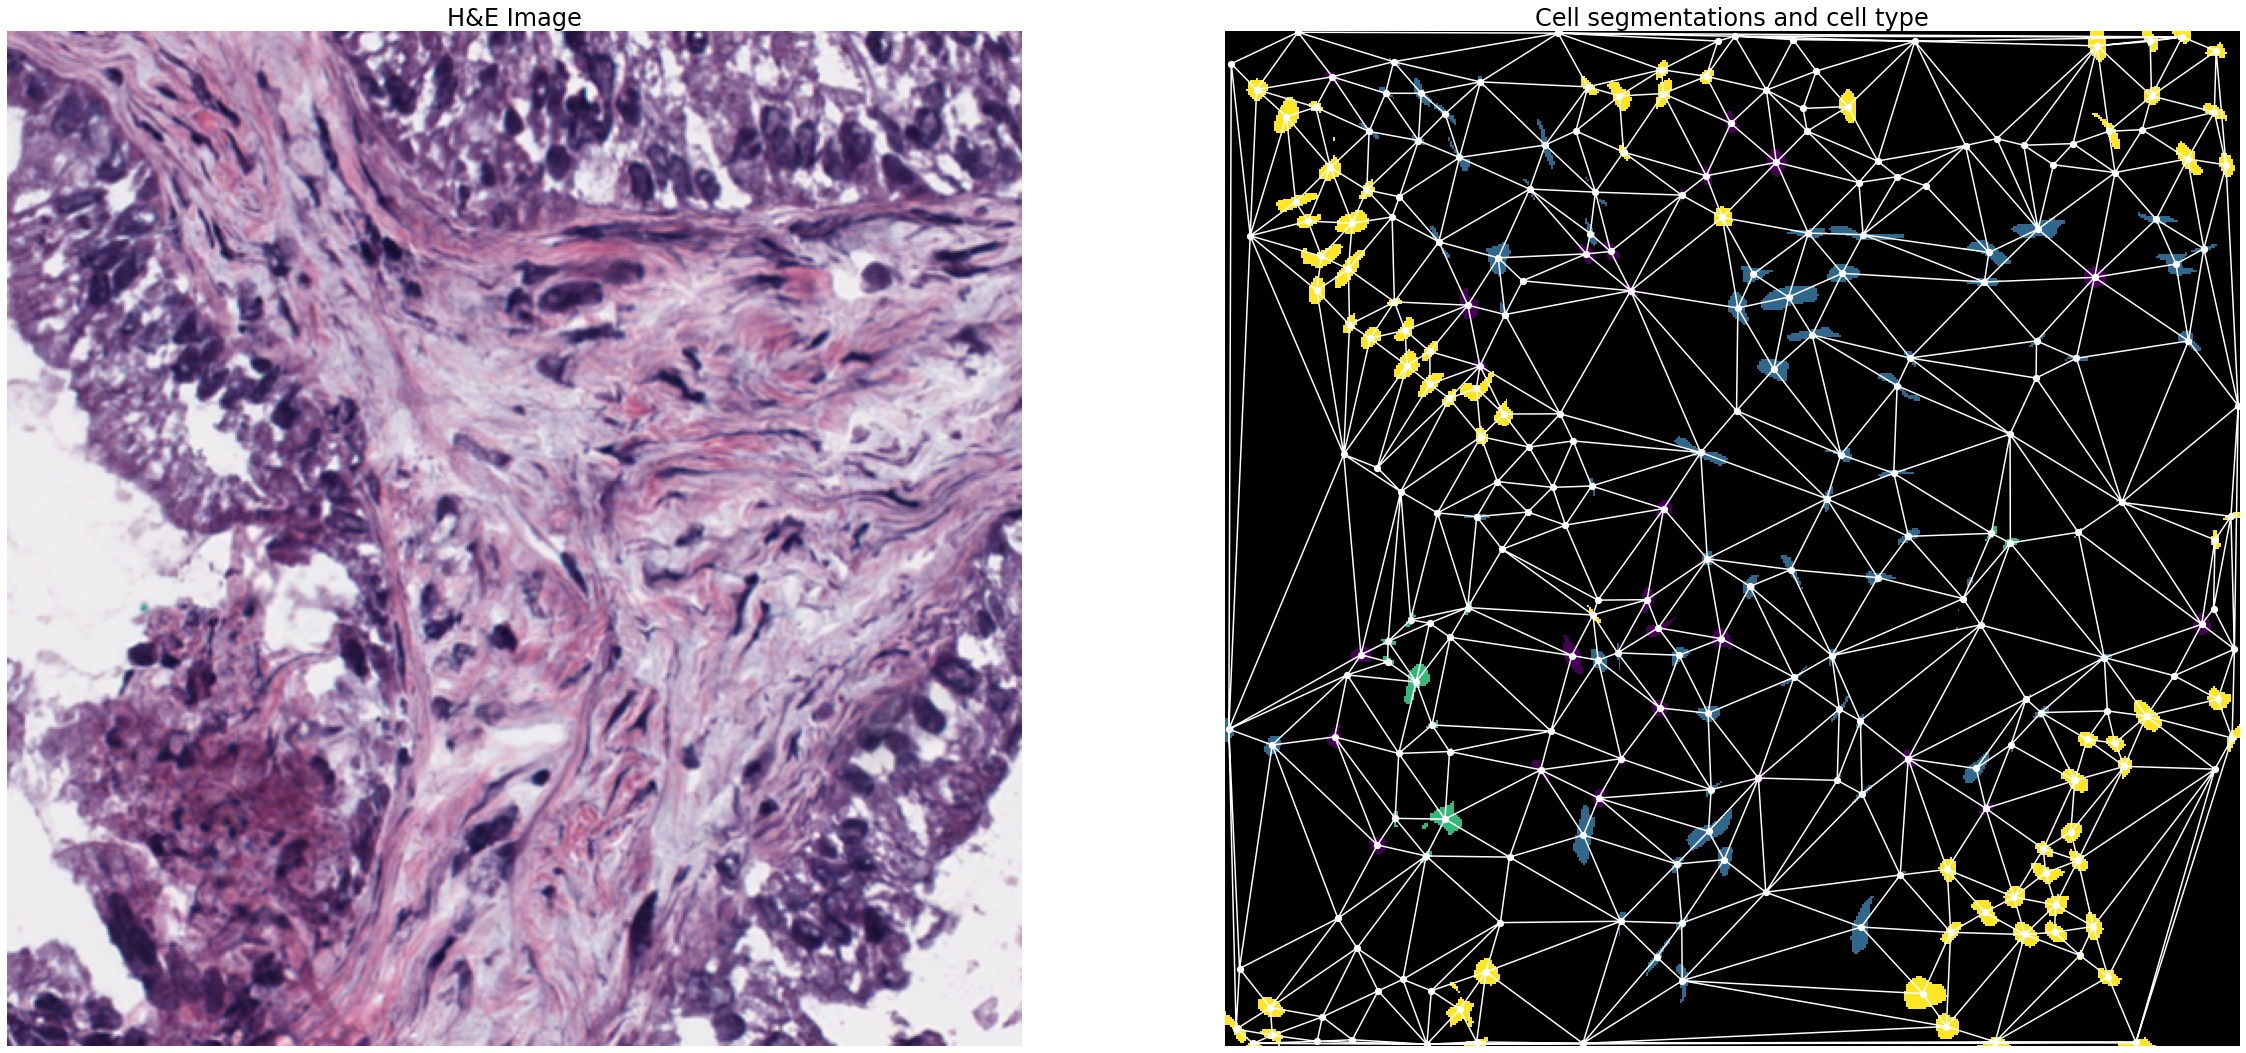

In [14]:
# Display a tile and its segmentation as a sanity check
n_tiles = filtered_tiles.shape[0]
index = np.random.choice(n_tiles)
print('Displaying tile %d of %d' %(index+1, n_tiles))
print(filtered_tiles.shape, label_images.shape, celltypes.shape, np.unique(celltypes))
axes = plot_cell_graph(filtered_tiles[index,...], label_images[index,...,0], celltypes[index,...])

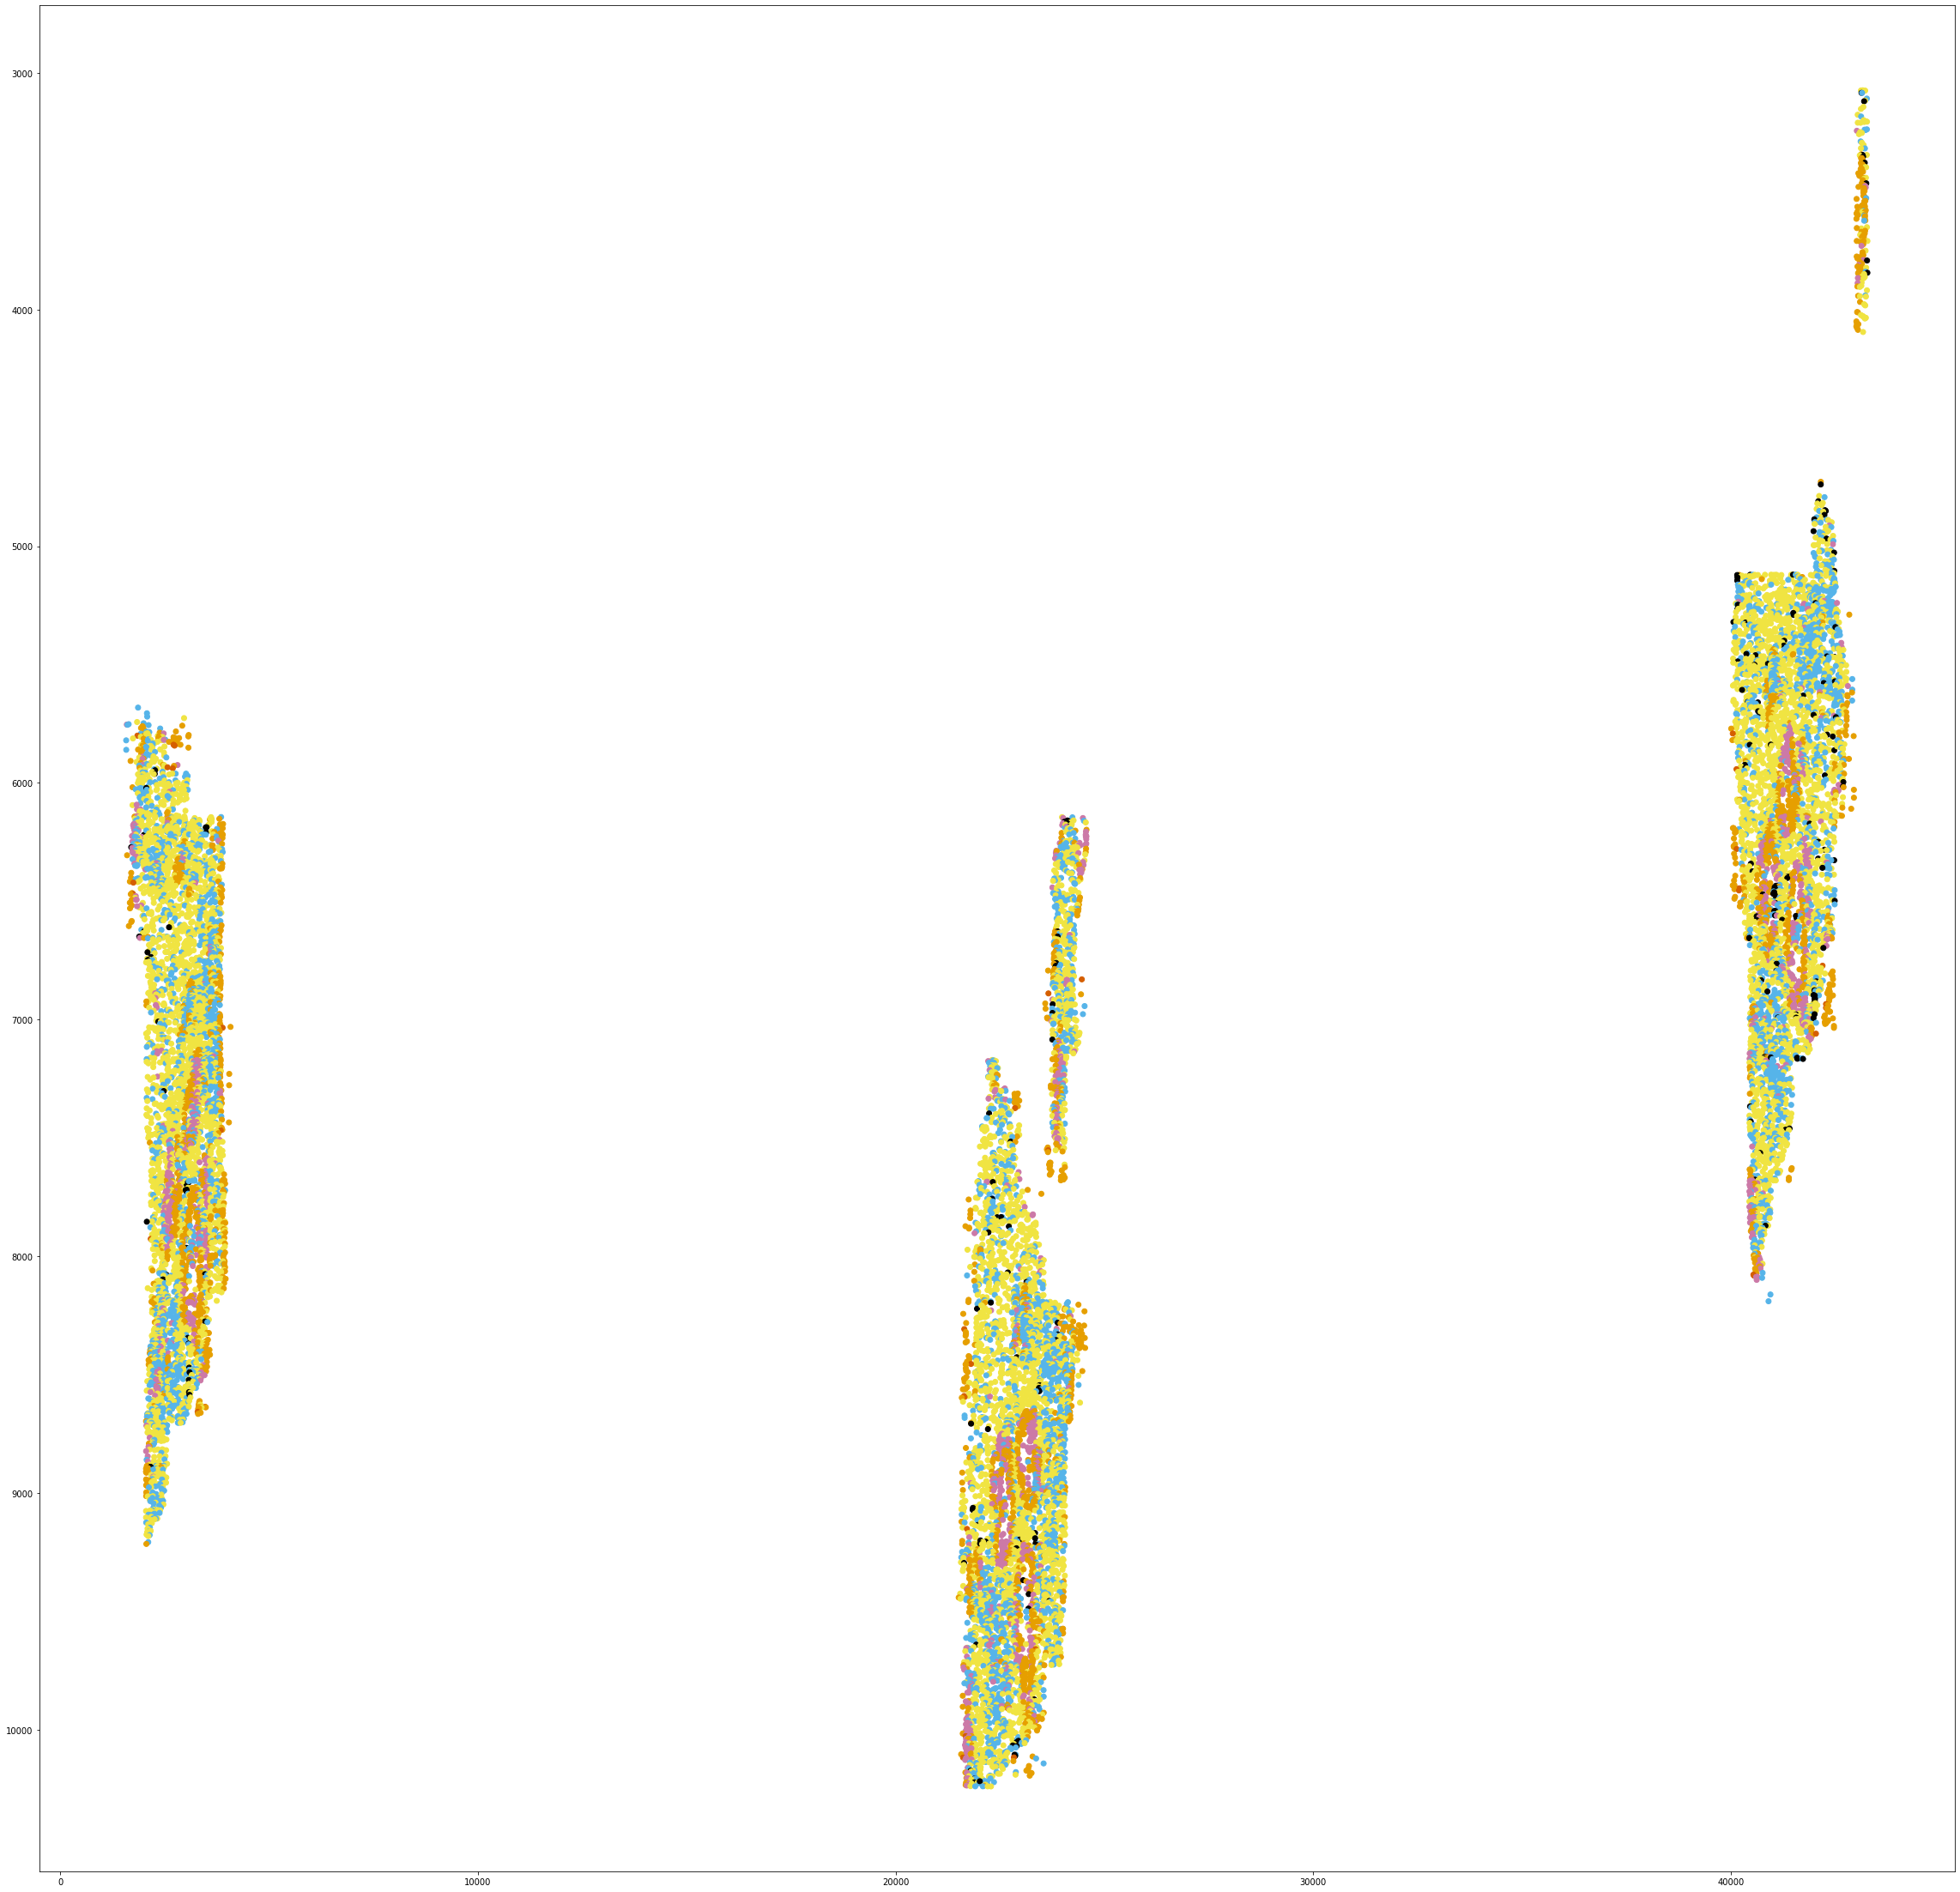

In [15]:
points, colors = plot_cell_graph_wsi(label_images[...,0], filtered_tile_locations, celltypes=celltypes)

In [16]:
wsi = wsi_utils.slide_to_img(slide, new_mpp=0.5)

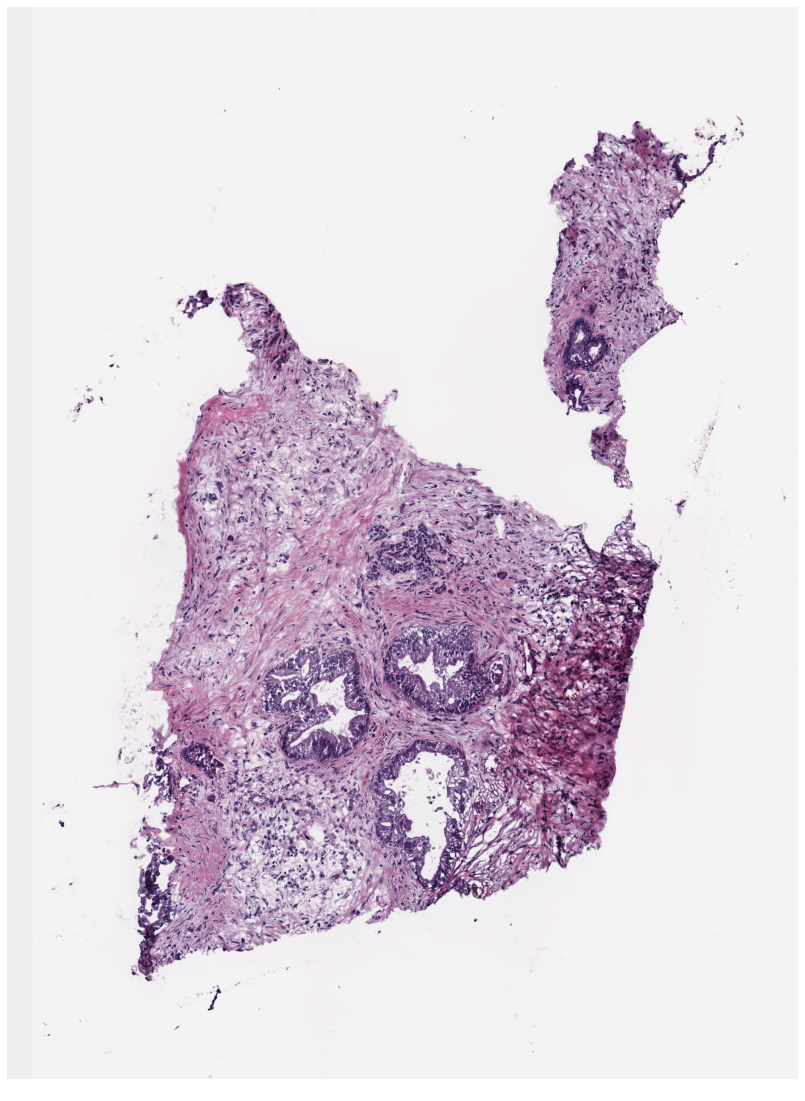

In [25]:
fig, axes = plt.subplots(1,1,figsize=(20,20))
wsi_view = wsi[5500:11000, 21000:25000]
axes.imshow(wsi_view)
axes.set_xlim(0,4000)
axes.set_ylim(5500,0)
axes.set_axis_off()    

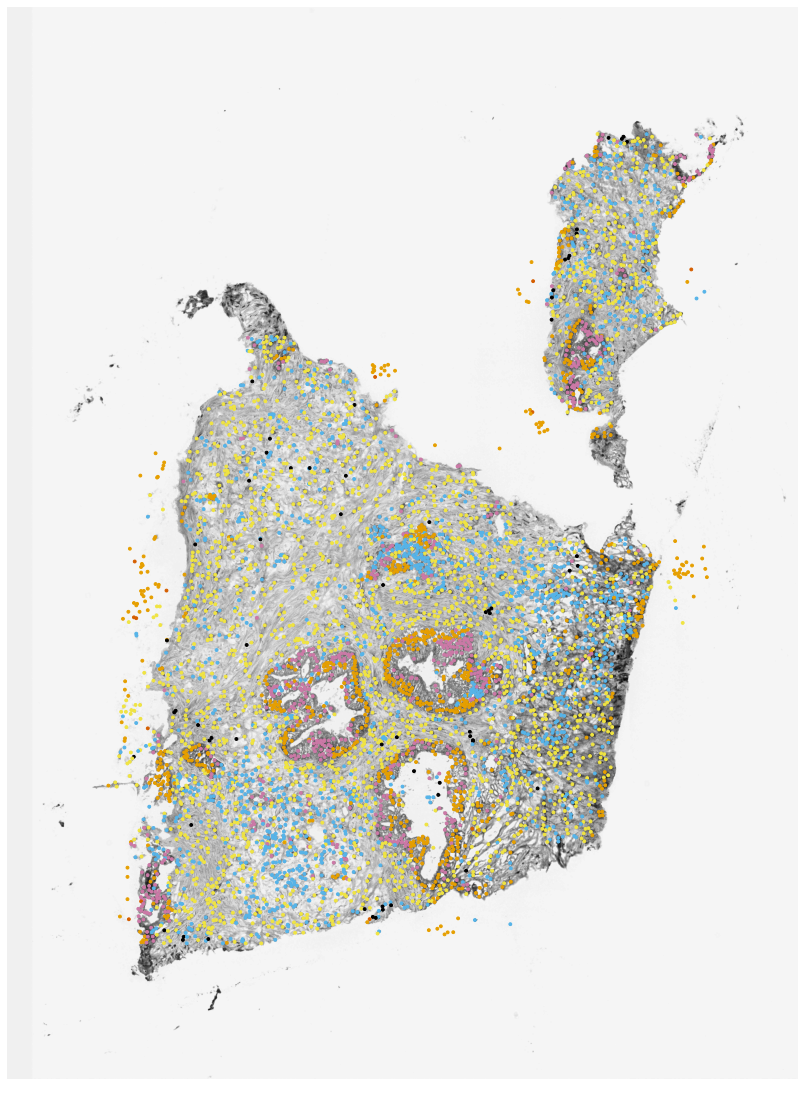

In [26]:
fig, axes = plt.subplots(1,1,figsize=(20,20))
from skimage.color import rgb2hsv
wsi_v = rgb2hsv(wsi_view)[...,-1]
axes.imshow(wsi_v, cmap='gray')
axes.scatter(points[:,0]-21000, points[:,1]-5500, color=colors, s=8)
axes.set_xlim(0,4000)
axes.set_ylim(5500,0)
axes.set_axis_off()    

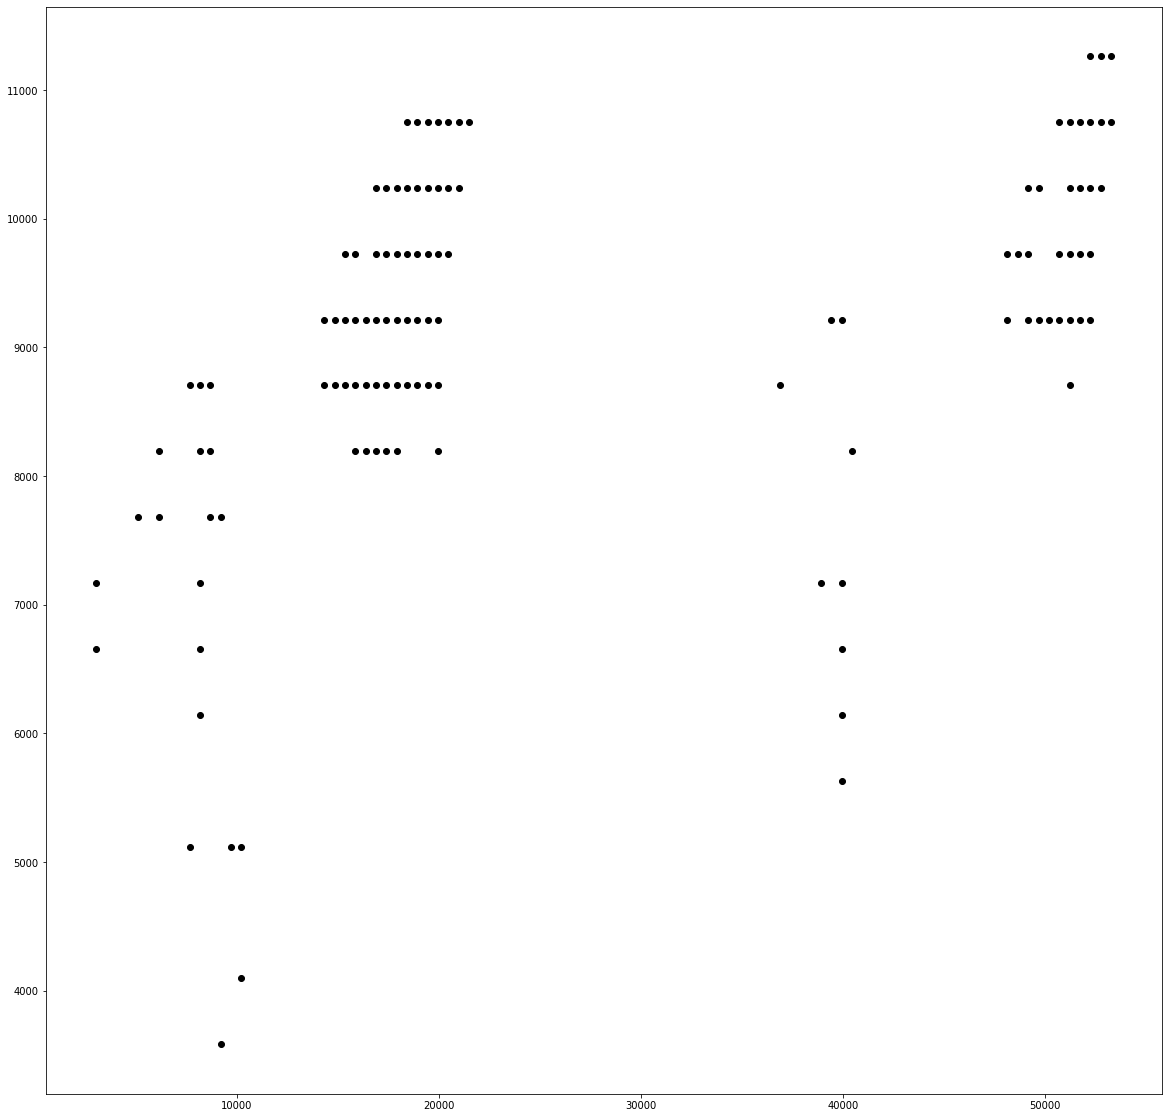

In [43]:
fig, axes = plt.subplots(1,1,figsize=(20,20))
axes.plot(filtered_tile_locations[:,1]*512, filtered_tile_locations[:,0]*512, 'ko')

In [73]:
print(sum([len(np.unique(li)) for li in label_images[...,0]]))

33086


In [49]:
print(np.unique(celltypes))

[-1.  0.  1.  2.  3.  4.  5.]
